# Question to be answered:

- Is the accuracy of model/human significantly better? In both force and mass questions?
- Is the distribution of responses significantly different?

In [2]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from torch.nn import Softmax
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS
from isaac.evaluation import predict_with_a_group_of_saved_models
from isaac.statistical_tests import z_test

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm


In [3]:
device = get_cuda_device_if_available()
print(device)

cuda:0


In [4]:
normalise_data = True
scaler_path = "scalers_js/passive_dual_scaler.sk"
network_dims = (len(BASIC_TRAINING_COLS), 25, 3, 0.5)
dataset_path = "../new_exp_data/exp7_passive.h5"
class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
multiclass = True
seq_end = 2700
step_size = 3

def get_question_predictions_for_group_of_models(question_type):    
    models = sorted(glob.glob("models/train_25_mb_with_js_data/best_mass_model_seed_*.pt"))

    group_predictions = []
    
    predictions = predict_with_a_group_of_saved_models(tqdm(models), network_dims, dataset_path, 
                                                       training_columns=BASIC_TRAINING_COLS, 
                                                       class_columns=class_columns, step_size=step_size, 
                                                       seq_end=seq_end, scaler_path=scaler_path,
                                                       arch=MultiBranchModel, multiclass=multiclass, trials=None)

    predictions = torch.stack(predictions)
    
    print(predictions.shape)
    if question_type == "mass":
        predictions = predictions[:, :, :, 0]
    else:
        predictions = predictions[:, :, :, 1]

    return predictions

def get_participant_accuracy(passive_responses, answer_column, question_type_answer):
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

def get_participant_accuracy_filtering_by_answer(passive_responses, answer_column, question_type_answer, filter_by_class):
    
    passive_responses = passive_responses.copy().query(question_type_answer+" == "+filter_by_class)
    
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

# T-test for MASS questions

## Load model's predictions

In [5]:
print("MASS")
question_type = "mass"
group_mass_prediction = get_question_predictions_for_group_of_models(question_type)
    
print("\nFORCE")
question_type = "force"
group_force_prediction = get_question_predictions_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


  0%|          | 0/25 [00:00<?, ?it/s]

torch.Size([25, 36, 3, 2])

FORCE


100%|██████████| 25/25 [00:12<00:00,  1.99it/s]

torch.Size([25, 36, 3, 2])


In [6]:
s = Softmax(dim=2)
group_force_prediction = s(group_force_prediction)
group_mass_prediction = s(group_mass_prediction)

In [7]:
mean_force_prediction = group_force_prediction.mean(dim=0)
mean_mass_prediction = group_mass_prediction.mean(dim=0)

In [8]:
all_predictions = torch.cat((mean_mass_prediction, mean_force_prediction), dim=1).numpy()

In [9]:
model_predictions_df = pd.DataFrame(data=all_predictions, columns=list(MASS_CLASS_COLS) + list(FORCE_CLASS_COLS))

In [10]:
import json

In [11]:
condition_world_variant = []
world_id = []

for condition_id in range(1, 5):
    filename = "../new_exp_data/physics_data%d.json" % condition_id
    fd = open(filename)
    sim_data = json.load(fd)
    
    for sim in sim_data:
        if sim["practice"]:
            continue
        condition_world_variant.append(sim["condition_world_variant"])
        world_id.append(sim["world_id"])

In [12]:
model_predictions_df["condition_world_variant"] = condition_world_variant
model_predictions_df["world_id"] = world_id

In [13]:
model_predictions_df.head()

,A,B,same,attract,none,repel,condition_world_variant,world_id
0,0.568650,0.041917,0.389433,0.343488,0.627056,0.029456,1,481
1,0.526954,0.078996,0.394050,0.772606,0.223615,0.003779,1,856
2,0.008267,0.833398,0.158335,0.927104,0.072048,0.000848,1,1819
3,0.460424,0.090315,0.449261,0.084841,0.595190,0.319968,1,566
4,0.510202,0.121099,0.368699,0.216320,0.645106,0.138574,1,821


## Load human results

In [14]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWa

In [15]:
rdata_path = "../new_exp_data/e7_passive_io_rtheta.rdata"
r['load'](rdata_path)

responses = r["tw"].query("practice == 0")

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


# Percentage of participants that chose each answer

In [16]:
passive_responses = []

for name, df in responses.groupby(["cond_worldvar", "world_id", "post_ent_mass.rtheta", "post_ent_rel.rtheta",
                                   "true_mass", "true_rel", 
                                   "post_att.rtheta", "post_none.rtheta", "post_rep.rtheta", 
                                   "post_same.rtheta", "post_A.rtheta", "post_B.rtheta"]):
    response = [name[0], name[1], name[2], name[3], name[4], name[5],
                name[6], name[7], name[8], name[9], name[10], name[11]]
    
    value_counts = df.resp_rel.value_counts()
    for col in FORCE_CLASS_COLS:
        response.append(value_counts[col])
    
    value_counts = df.resp_mass.value_counts()
    for col in MASS_CLASS_COLS:
        response.append(value_counts[col])
        
    avg_conf_mass = df.conf_mass.mean()
    response.append(avg_conf_mass)
    avg_conf_rel = df.conf_rel.mean()
    response.append(avg_conf_rel)
        
    passive_responses.append(response)

In [17]:
passive_responses = pd.DataFrame(data=passive_responses, 
                                 columns=["cond_worldvar", "world_id", 
                                          "post_ent_mass.rtheta", "post_ent_rel.rtheta",
                                          "true_mass", "true_rel", "attract_io", "none_io", "repel_io",
                                          "same_io", "A_io", "B_io"] + list(FORCE_CLASS_COLS) + list(MASS_CLASS_COLS) + 
                                         ["conf_mass", "conf_rel"])

In [18]:
passive_responses.head()

,cond_worldvar,world_id,post_ent_mass.rtheta,post_ent_rel.rtheta,true_mass,true_rel,attract_io,none_io,repel_io,same_io,A_io,B_io,attract,none,repel,A,B,same,conf_mass,conf_rel
0,1,1218,0.000827,1.402287,A,repel,0.116278,0.442520,0.441202,0.000053,9.999471e-01,1.306524e-10,4,2,19,13,5,7,67.52,73.08
1,1,1736,0.022527,1.413136,B,none,0.294347,0.549061,0.156592,0.002171,1.061167e-05,9.978184e-01,2,10,13,4,13,8,71.56,71.00
2,1,1758,0.049913,1.555458,B,repel,0.241375,0.368009,0.390617,0.005595,3.771451e-08,9.944045e-01,8,6,11,1,18,6,74.00,69.48
3,1,1819,0.243940,0.924914,B,attract,0.736875,0.245450,0.017676,0.040165,5.755379e-05,9.597772e-01,16,1,8,5,15,5,72.60,77.20
4,1,438,0.051500,1.305047,same,repel,0.127337,0.250658,0.622005,0.994825,1.722333e-03,3.453153e-03,4,7,14,7,9,9,61.20,67.88


In [19]:
passive_responses["cond_worldvar"] = passive_responses["cond_worldvar"].astype("int64")
passive_responses["world_id"] = passive_responses["world_id"].astype("int64")

In [20]:
passive_responses = passive_responses.merge(model_predictions_df, left_on=["cond_worldvar", "world_id"], 
                                            right_on=["condition_world_variant", "world_id"], 
                                            suffixes=("_human", "_rnn"))

In [21]:
passive_responses = passive_responses.sort_values(by=["condition_world_variant", "true_mass", "true_rel"])

## Plot distribution of answers

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize

In [23]:
def softmax(values, temperature):
    exp_values = np.exp(values / temperature)
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

def fit_softmax_temperature(model_suffix, class_columns):
    model_values = passive_responses[[col + model_suffix for col in class_columns]].values
    human_values = passive_responses[[col + "_human" for col in class_columns]].values
    
    def nll(temperature):
        softmax_values = softmax(model_values, temperature)
        val = -np.sum(human_values * np.log(softmax_values))
        return val
    
    return minimize(nll, np.random.rand()).x[0]

In [26]:
rnn_mass_temperature = fit_softmax_temperature("_rnn", MASS_CLASS_COLS)
io_mass_temperature =  fit_softmax_temperature("_io", MASS_CLASS_COLS)
rnn_force_temperature = fit_softmax_temperature("_rnn", FORCE_CLASS_COLS)
io_force_temperature =fit_softmax_temperature("_io", FORCE_CLASS_COLS)

In [27]:
regressed_mass_with_rnn = softmax(passive_responses[[col + "_rnn" for col in MASS_CLASS_COLS]].values, rnn_mass_temperature)
regressed_mass_with_io = softmax(passive_responses[[col + "_io" for col in MASS_CLASS_COLS]].values, io_mass_temperature)
regressed_force_with_rnn = softmax(passive_responses[[col + "_rnn" for col in FORCE_CLASS_COLS]].values, rnn_force_temperature)
regressed_force_with_io = softmax(passive_responses[[col + "_io" for col in FORCE_CLASS_COLS]].values, io_force_temperature)

In [28]:
human_mass_columns = passive_responses[[col + "_human" for col in MASS_CLASS_COLS]]
passive_responses[[col + "_human" for col in MASS_CLASS_COLS]] = human_mass_columns.values / human_mass_columns.sum(axis=1).values.reshape(-1, 1)

human_force_columns = passive_responses[[col + "_human" for col in FORCE_CLASS_COLS]]
passive_responses[[col + "_human" for col in FORCE_CLASS_COLS]] = human_force_columns.values / human_force_columns.sum(axis=1).values.reshape(-1, 1)

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


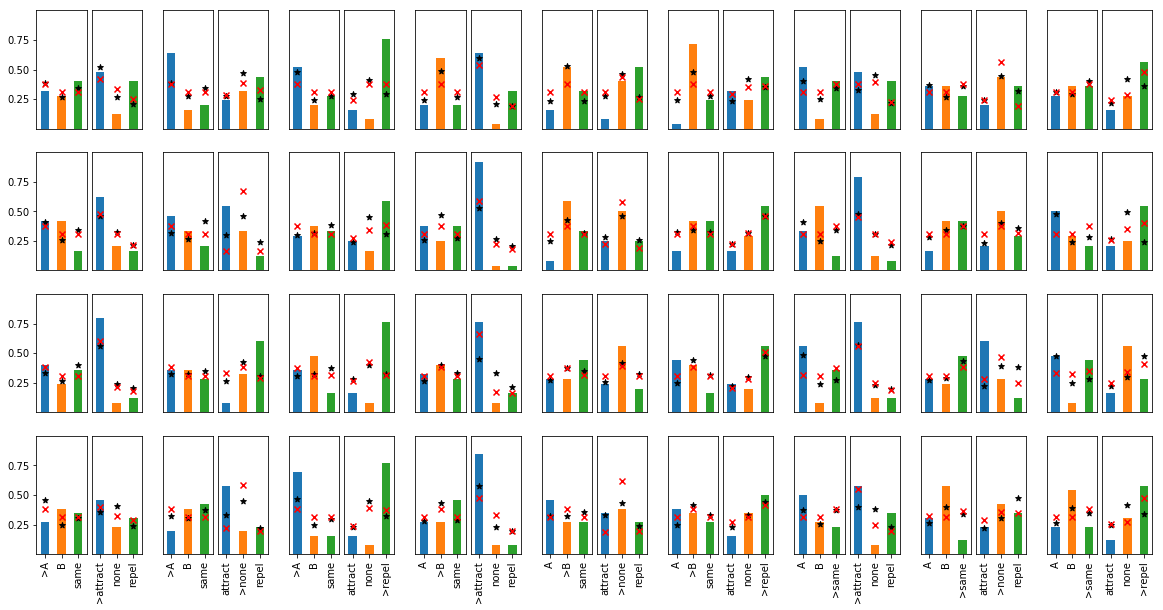

In [29]:
nrows = 4
ncols = 9
fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(nrows, ncols, wspace=0.2, hspace=0.2)

for i in range(36):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    ax1 = plt.Subplot(fig, inner[0])
    passive_responses[["A_human", "B_human", "same_human"]].iloc[i].plot(kind="bar", ax=ax1)
    xticks = ax1.get_xticks()
    ax1.scatter(xticks, regressed_mass_with_rnn[i], zorder=10, c="k", marker="*")
    ax1.scatter(xticks, regressed_mass_with_io[i], zorder=10, c="r", marker="x")
    ax1.set_ylim(0, 1)
    
    ax2 = plt.Subplot(fig, inner[1])
    passive_responses[["attract_human", "none_human", "repel_human"]].iloc[i].plot(kind="bar", ax=ax2)
    xticks = ax2.get_xticks()
    ax2.scatter(xticks, regressed_force_with_rnn[i], zorder=10, c="k", marker="*")
    ax2.scatter(xticks, regressed_force_with_io[i], zorder=10, c="r", marker="x")
    ax2.set_ylim(0, 1)
    
    row = i // ncols
    if row != (nrows - 1):
        ax1.set_xticks([])
        ax2.set_xticks([])
    else:
        mass_labels = []
        for label in MASS_CLASS_COLS:
            if label == passive_responses.iloc[i].true_mass:
                label = ">" + label
            mass_labels.append(label)
        ax1.set_xticklabels(mass_labels)

        rel_labels = []
        for label in FORCE_CLASS_COLS:
            if label == passive_responses.iloc[i].true_rel:
                label = ">" + label
            rel_labels.append(label)
        ax2.set_xticklabels(rel_labels)

    ax2.set_yticks([])
    col = i % ncols
    if col != 0:
        ax1.set_yticks([])
    else:
        ax1.set_yticks([0.25, 0.5, 0.75])
    
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)

fig.show()

## Other stuff

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [73]:
from sklearn.linear_model import LinearRegression

In [247]:
def plot_correlation_between_accuracy_and_average_softmax(true_class):
    f, axes = plt.subplots(1, 1, figsize=(10, 10))
    c = ["r", "y", "b"]
    
    human_accuracy = []
    rnn_avg_softmax = []
    for i, cl in enumerate(passive_responses[true_class]):
        human_accuracy.append(passive_responses[cl+"_human"].iloc[i])
        rnn_avg_softmax.append(passive_responses[cl+"_rnn"].iloc[i])
    
    
    # corr_coef, pval = spearmanr(human_accuracy, rnn_avg_softmax)
    corr_coef = np.corrcoef(human_accuracy, rnn_avg_softmax)[0][1]
    pval = 0
    print(corr_coef, pval)
        
    plt.scatter(rnn_avg_softmax, human_accuracy, c="b", marker="o", s=50)

    axes.set_title("Spearman Correlation = %.3f" % corr_coef, fontsize=35)
    axes.set_xlabel("Avg softmax value", fontsize=35)
    axes.set_ylabel("Participant accuracy", fontsize=35)
    # axes.legend(fontsize=35)
    axes.set_xlim((-0.05, 1.05))
    axes.set_ylim((-0.05, 1.05))
    axes.tick_params(axis='both', which='major', labelsize=35)
    axes.grid()

    plt.tight_layout()    
    
def plot_correlation_between_accuracy_and_uncertainty(true_class):
    f, axes = plt.subplots(1, 1, figsize=(10, 10))
    c = ["r", "y", "b"]
    
    if true_class == "true_mass":
        io_col = "post_ent_mass.rtheta"
    else:
        io_col = "post_ent_rel.rtheta"
        
    human_accuracy = []
    io_unc = []
    for i, cl in enumerate(passive_responses[true_class]):
        human_accuracy.append(passive_responses[cl+"_human"].iloc[i])
        io_unc.append(passive_responses[io_col].iloc[i])
    
    
    corr_coef, pval = spearmanr(human_accuracy, io_unc)
    print(corr_coef, pval)
        
    plt.scatter(io_unc, human_accuracy, c="b", marker="o", s=50)

    axes.set_title("Spearman Correlation = %.3f" % corr_coef, fontsize=35)
    axes.set_xlabel("IO uncertainty", fontsize=35)
    axes.set_ylabel("Participant accuracy", fontsize=35)
    # axes.legend(fontsize=35)
    # axes.set_xlim((-0.05, 1.05))
    axes.set_ylim((-0.05, 1.05))
    axes.tick_params(axis='both', which='major', labelsize=35)
    axes.grid()

    plt.tight_layout()    
    
def plot_correlation():
    
    nrows = 2
    ncols = 3
    fig = plt.figure(figsize=(20, 10))
    outer = gridspec.GridSpec(nrows, ncols, wspace=0.1, hspace=0.2)
    
    for i, cl in enumerate(MASS_CLASS_COLS + FORCE_CLASS_COLS):
        inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

        col = i % ncols
        row = i // ncols
        if row == 0:
            true_class = "true_mass"
        else:
            true_class = "true_rel"
            
        ax = plt.Subplot(fig, outer[i])
        ax.set_title(cl, pad=25)
        ax.axis('off')
        fig.add_subplot(ax)
        
        for j, model_suffix in enumerate(["_rnn", "_io"]):
            ax = plt.Subplot(fig, inner[j])

            is_example_correct = (passive_responses[true_class] == cl)
            class_examples = passive_responses[is_example_correct]
            ax.scatter(class_examples[cl+model_suffix], class_examples[cl+"_human"], marker="o",
                         label=cl+" example")
            ax.set_xlim(-0.05, 1.05)
        
            other_examples = passive_responses[~is_example_correct]
            ax.scatter(other_examples[cl+model_suffix], other_examples[cl+"_human"], marker="x",
                         label=cl+" example")
            ax.set_ylim(-0.05, 1.05)
            
            corr_coef, pval = spearmanr(passive_responses[cl+model_suffix], passive_responses[cl+"_human"])
            ax.set_title("ρ=%.3f" % corr_coef)
            
            if row == 0:
                ax.set_xticklabels([])
            if col != 0 or j == 1:
                ax.set_yticklabels([])
            ax.grid()
            fig.add_subplot(ax)

    plt.tight_layout()
    plt.savefig("cogsci_images/"+true_class.split("_")[1]+"_softmax_correlation.pdf")
    plt.savefig("cogsci_images/"+true_class.split("_")[1]+"_softmax_correlation.jpg")

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


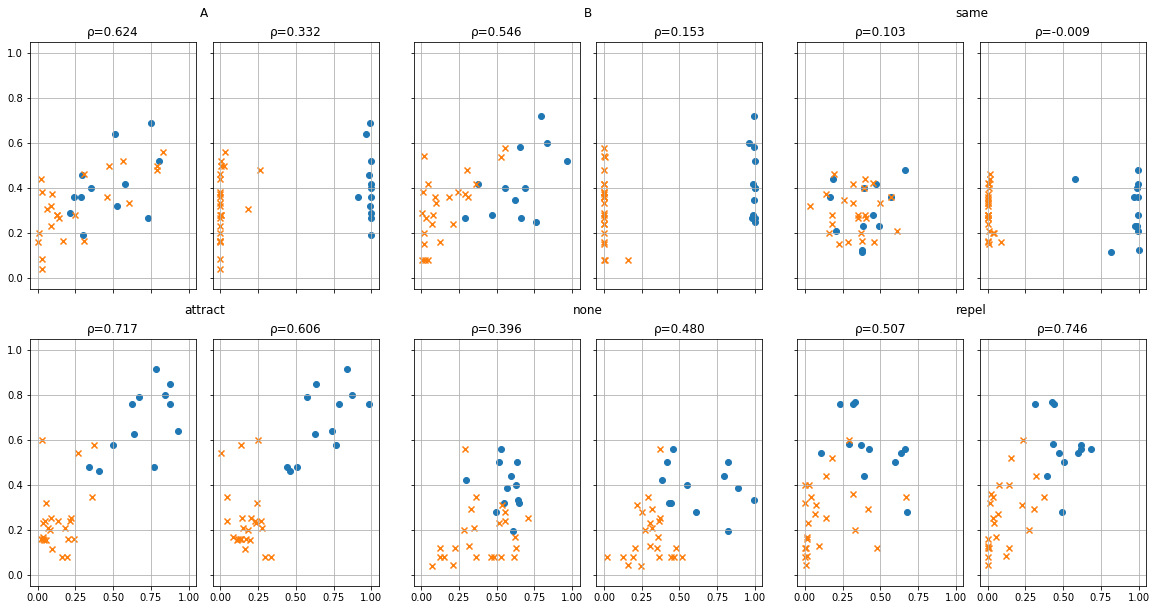

In [248]:
plot_correlation()

[0.36515063] 0.228865
[0.31663322] 0.25196373
[0.05543289] 0.2783503
[0.09758169] 0.31706610833232435
[0.10038491] 0.3179091612928416
[0.0040319] 0.29657430532046963


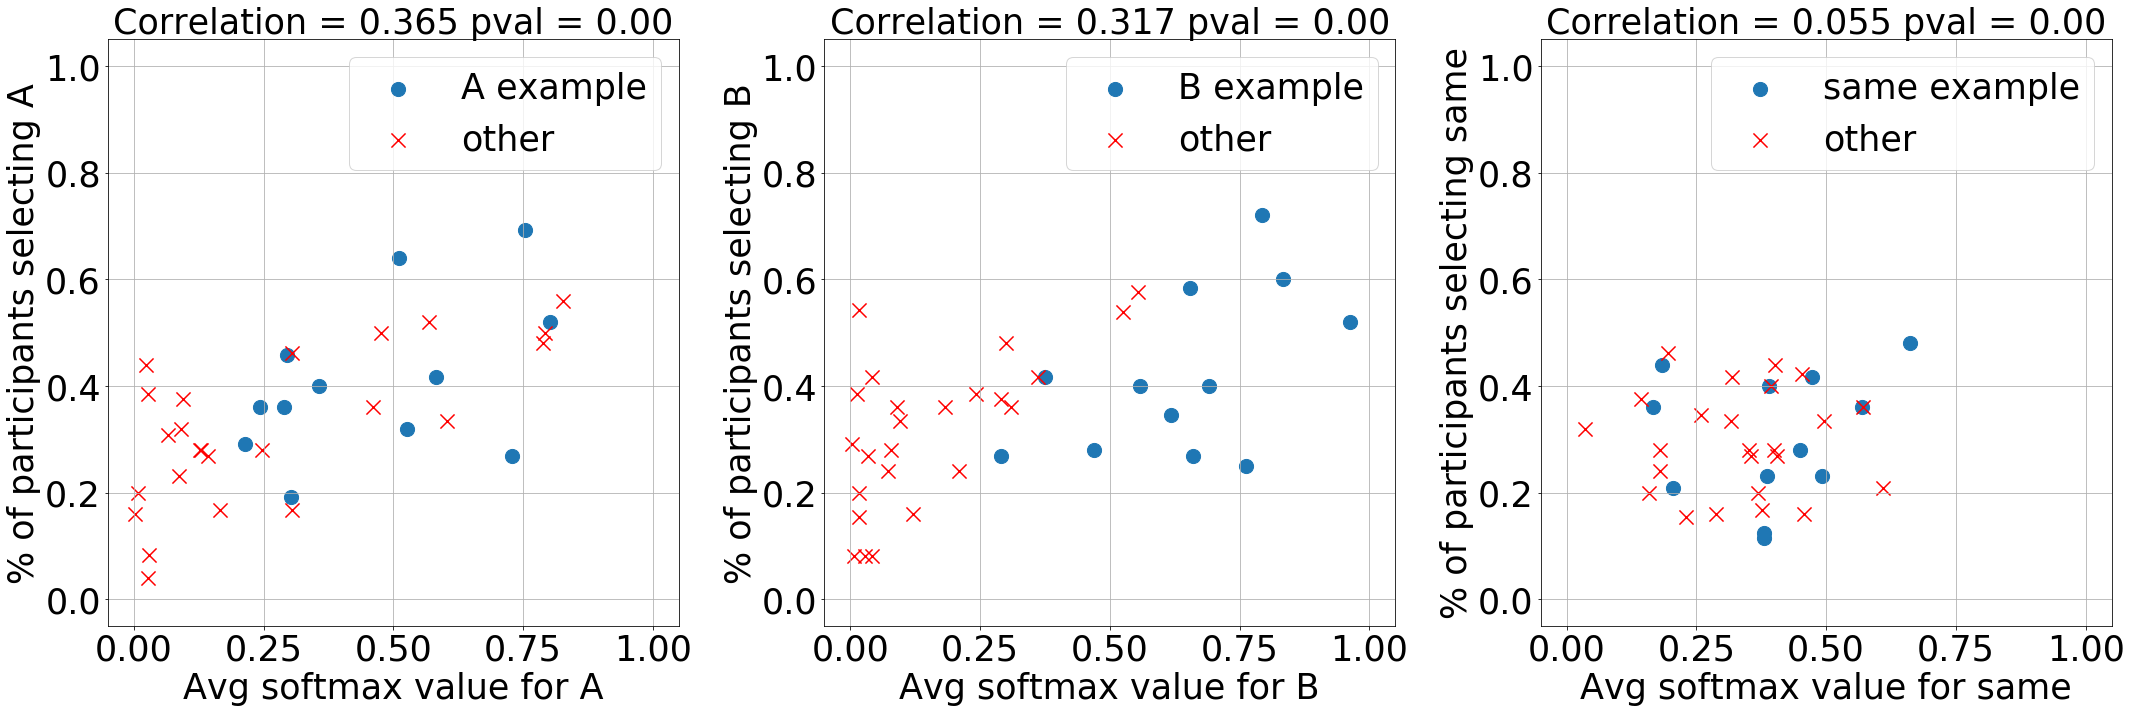

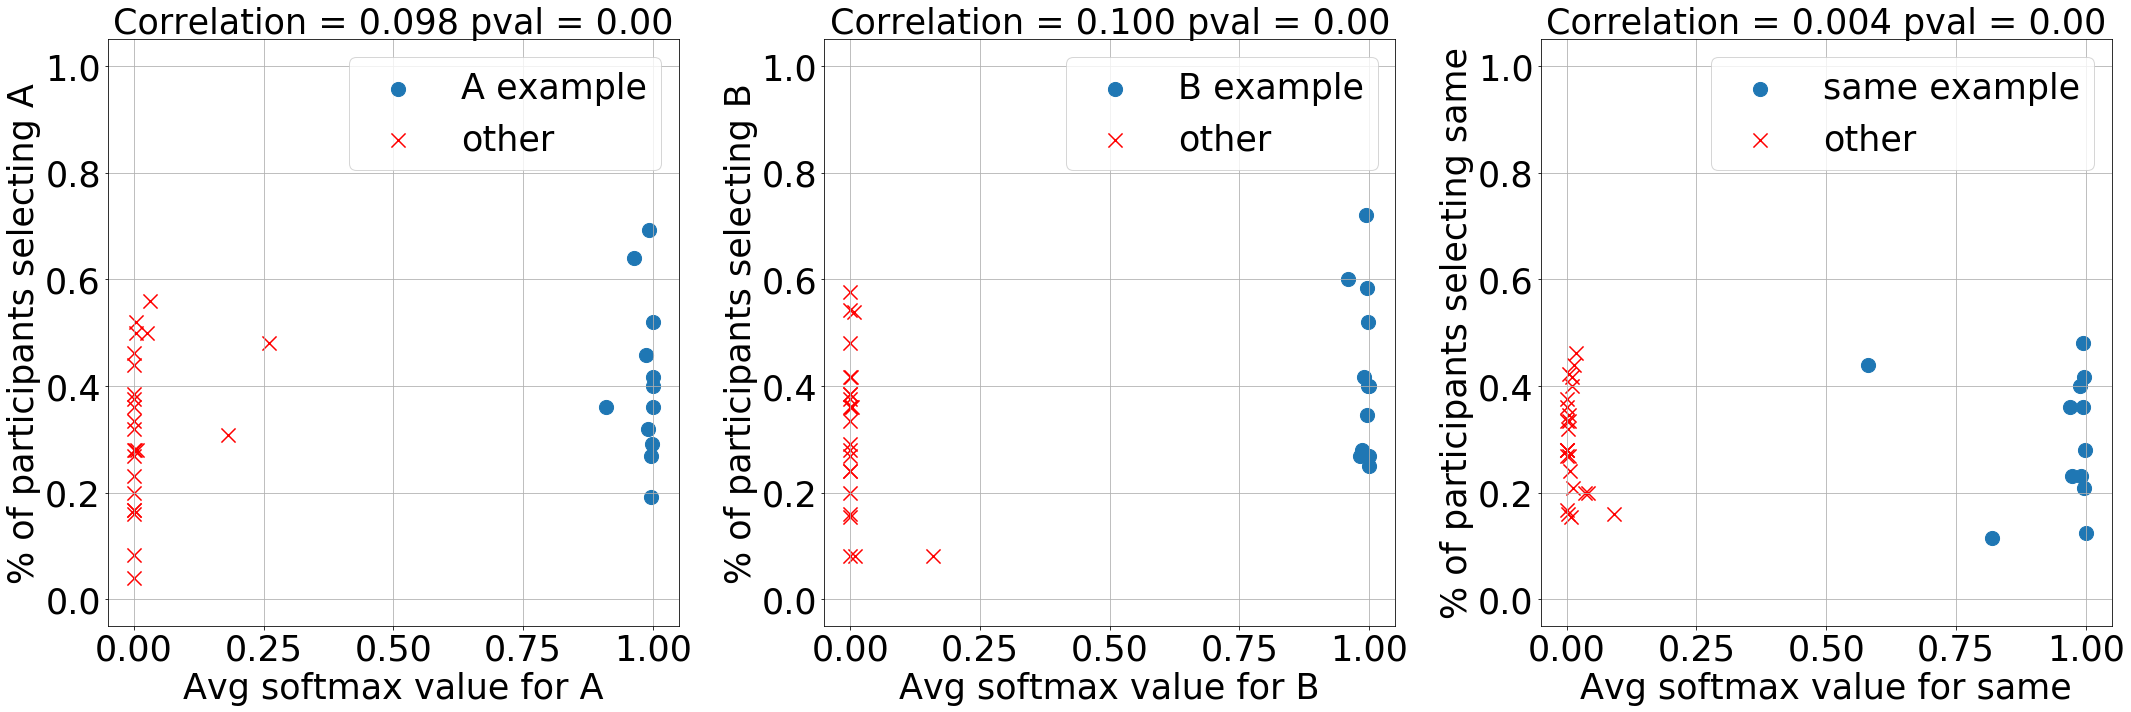

In [90]:
plot_correlation(MASS_CLASS_COLS, "true_mass", "_rnn")
plot_correlation(MASS_CLASS_COLS, "true_mass", "_io")

In [ ]:
def entropy_response_rnn(responses):
    return -np.sum(responses * np.log2(responses), axis=1)

In [ ]:
def get_percentage_of_participants_getting_answer_right(df, question_type):
    
    got_question_right = []
    for _, trial in df.iterrows():
        if question_type == "mass":
            got_question_right.append(trial[trial.true_mass+"_human"])
        elif question_type == "force":
            got_question_right.append(trial[trial.true_rel+"_human"])

    df["got_" + question_type + "_right"] = got_question_right

In [ ]:
def get_rnn_answer(df, question_type):
    
    if question_type == "mass":
        class_columns = MASS_CLASS_COLS
    elif question_type == "force":
        class_columns = FORCE_CLASS_COLS
    
    rnn_answer = []
    rnn_class_probabilities_cols = [cl + "_rnn" for cl in class_columns]

    df["rnn_"+question_type+"_answer"] = [class_columns[x] for x in df[rnn_class_probabilities_cols].values.argmax(axis=1)]

In [ ]:
get_percentage_of_participants_getting_answer_right(passive_responses, "mass")
get_percentage_of_participants_getting_answer_right(passive_responses, "force")

In [ ]:
get_rnn_answer(passive_responses, "mass")
get_rnn_answer(passive_responses, "force")

In [ ]:
max_entropy = entropy_response_rnn(np.array([[1/3, 1/3, 1/3]]))

def plot_entropy_correlation(question_type, true_class, got_question_right, ylabel=None):
    
    if ylabel is None:
        ylabel = "Participants' accuracy"
        
    if question_type == "mass":
        class_columns = MASS_CLASS_COLS
    elif question_type == "force":
        class_columns = FORCE_CLASS_COLS
    
    is_example_correct = (passive_responses[true_class] == passive_responses["rnn_"+question_type+"_answer"])
    
    rnn_class_columns = [cl + "_rnn" for cl in class_columns]
    passive_responses["answer_entropy"] = max_entropy - entropy_response_rnn(passive_responses[rnn_class_columns])
    
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
        
    passive_responses[is_example_correct].plot(kind="scatter", x="answer_entropy", y=got_question_right, 
                                               marker="o", label="rnn is correct", s=200, ax=ax)
    passive_responses[~is_example_correct].plot(kind="scatter", x="answer_entropy", y=got_question_right, 
                                                c="r", marker="x", label="rnn is wrong", s=200, ax=ax, 
                                                linewidth=4)

    # passive_responses.plot(kind="scatter", x="answer_entropy", y=got_question_right, marker="o", s=50, ax=ax)
    corr_coef = np.corrcoef(passive_responses.answer_entropy, passive_responses[got_question_right])[0][1]
    
    ax.set_xticks(np.arange(0, 1.6, 0.2))
    ax.set_xticklabels(["%.1f" % x for x in ax.get_xticks()], fontweight='bold')    
    ax.set_yticklabels(["%.1f" % y for y in ax.get_yticks()], fontweight='bold')

    plt.title("Correlation = %.3f" % corr_coef, fontsize=30, fontweight='bold')
    plt.xlabel("RNN "+question_type+" certainty", fontsize=25, fontweight='bold')
    plt.ylabel(ylabel, fontsize=25, fontweight='bold')
    plt.legend(fontsize=25, prop={'size': 25, 'weight':'bold'})
    plt.xlim((-0.05, max_entropy))
    # plt.ylim((-0.05, 1.05))
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    plt.grid()
    plt.tight_layout()
    
    # plt.show()

In [ ]:
plot_entropy_correlation("force", "true_rel", "got_force_right")
plt.savefig("cogsci_images/force_entropy_correct_correlation.pdf")
plt.savefig("cogsci_images/force_entropy_correct_correlation.jpg")

plot_entropy_correlation("mass", "true_mass", "got_mass_right")
plt.savefig("cogsci_images/mass_entropy_correct_correlation.pdf")
plt.savefig("cogsci_images/mass_entropy_correct_correlation.jpg")

In [ ]:
plot_entropy_correlation("force", "true_rel", "conf_rel", ylabel="Avg. participant confidence")
plt.savefig("cogsci_images/force_entropy_confidence_correlation.pdf")
plt.savefig("cogsci_images/force_entropy_confidence_correlation.jpg")

plot_entropy_correlation("mass", "true_mass", "conf_mass", ylabel="Avg. participant confidence")
plt.savefig("cogsci_images/mass_entropy_confidence_correlation.pdf")
plt.savefig("cogsci_images/mass_entropy_confidence_correlation.jpg")

In [ ]:
from scipy.stats import spearmanr

def plot_entropy_correlation(question_type, true_class):
        
    if question_type == "mass":
        class_columns = MASS_CLASS_COLS
        post_entropy_col = "post_ent_mass.rtheta"
    elif question_type == "force":
        class_columns = FORCE_CLASS_COLS
        post_entropy_col = "post_ent_rel.rtheta"
        
    passive_responses[post_entropy_col+"_copy"] = max_entropy - passive_responses[post_entropy_col]
    
    is_example_correct = (passive_responses[true_class] == passive_responses["rnn_"+question_type+"_answer"])
    
    rnn_class_columns = [cl + "_rnn" for cl in class_columns]
    passive_responses["answer_entropy"] = max_entropy - entropy_response_rnn(passive_responses[rnn_class_columns])
    
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    passive_responses[is_example_correct].plot(kind="scatter", x="answer_entropy", y=post_entropy_col+"_copy", 
                                               marker="o", label="rnn is correct", s=100, ax=ax)
    passive_responses[~is_example_correct].plot(kind="scatter", x="answer_entropy", y=post_entropy_col+"_copy", 
                                                c="r", marker="x", label="rnn is wrong", s=100, ax=ax)

    # passive_responses.plot(kind="scatter", x="answer_entropy", y=got_question_right, marker="o", s=50, ax=ax)
    corr_coef = np.corrcoef(passive_responses.answer_entropy, passive_responses[post_entropy_col+"_copy"])[0][1]
    
    plt.title("Correlation = %.3f" % corr_coef, fontsize=20)
    plt.xlabel("RNN "+question_type+" certainty", fontsize=20)
    plt.ylabel("IO "+question_type+" information", fontsize=20)
    plt.legend(fontsize=20)
    plt.xlim(right=max_entropy)
    plt.ylim(bottom=0)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.tight_layout()

In [ ]:
plot_entropy_correlation("force", "true_rel")
plt.savefig("cogsci_images/force_entropy_IO_correlation.pdf")
plt.savefig("cogsci_images/force_entropy_IO_correlation.jpg")

plot_entropy_correlation("mass", "true_mass")
plt.savefig("cogsci_images/mass_entropy_IO_correlation.pdf")
plt.savefig("cogsci_images/mass_entropy_IO_correlation.jpg")
# report that taking the log transform of the post_ent doesn't improve the mass correlation

In [ ]:
def plot_entropy_correlation(question_type, got_question_right, ylabel="Avg. participant confidence"):
        
    if question_type == "mass":
        class_columns = MASS_CLASS_COLS
        post_entropy_col = "post_ent_mass.rtheta"
    elif question_type == "force":
        class_columns = FORCE_CLASS_COLS
        post_entropy_col = "post_ent_rel.rtheta"
        
    passive_responses[post_entropy_col+"_copy"] = max_entropy - passive_responses[post_entropy_col]    
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    passive_responses.plot(kind="scatter", x=post_entropy_col+"_copy", y=got_question_right, s=100, ax=ax) 
    corr_coef, pval = spearmanr(passive_responses[got_question_right], passive_responses[post_entropy_col+"_copy"])
    print(pval)
    
    plt.title("Correlation = %.3f" % corr_coef, fontsize=20)
    plt.xlabel("IO "+question_type+" information", fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    # plt.legend(fontsize=20)
    plt.xlim(right=max_entropy)
    # plt.ylim((0, 1))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.tight_layout()

In [ ]:
passive_responses.columns

In [ ]:
plot_entropy_correlation("force", "got_force_right", ylabel="Participant Force Accuracy")
plt.savefig("cogsci_images/force_IO_correct_correlation.pdf")
plt.savefig("cogsci_images/force_IO_correct_correlation.jpg")

plot_entropy_correlation("mass", "got_mass_right", ylabel="Participant Mass Accuracy")
plt.savefig("cogsci_images/mass_IO_correct_correlation.pdf")
plt.savefig("cogsci_images/mass_IO_correct_correlation.jpg")

In [ ]:
plot_entropy_correlation("force", "conf_rel")
plt.savefig("cogsci_images/force_IO_confidence_correlation.pdf")
plt.savefig("cogsci_images/force_IO_confidence_correlation.jpg")

plot_entropy_correlation("mass", "conf_mass")
plt.savefig("cogsci_images/mass_IO_confidence_correlation.pdf")
plt.savefig("cogsci_images/mass_IO_confidence_correlation.jpg")